# Plotting cross section ratios as a function of Bjorken-x

In [2]:
import uproot, time, sys
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
import ROOT as r
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, He4_dict, He3_dict


Welcome to JupyROOT 6.30/04


\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [3]:
start_time = time.time()
r.EnableImplicitMT()
folder = 'multi'

ntg = 'Th232' #What is the nuclei in numerator?
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' #What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' #Aluminium dummy target
dang = 20.0 #What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] #What are your desired central momenta (just the magnitude)
cafe_report_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/reportfiles/'
tinfo_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/HMS_runlist.txt'
bin_num = 32 * len(dmom) #half percent bins according to the resolution of the spectrometer (-8% to 8%)
bin_eprime_low = 2.22
bin_eprime_high = bin_eprime_low + 0.0125 * bin_num
print("bin_eprime_high", bin_eprime_high)

#Kinematic variables
ts = dang #Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  #Target
thick = target_info[ntg][2] #g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

#Constants
Ei, Mp = 10.54, 0.93825 #Beam energy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 #Avogadro's number and charge in 1 electron
al_den, length = 2.699, 10. #Density of aluminum can and length of can
dpp_up, dpp_down = 15.0, -15.0 #Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))
for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 #mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  #diff solid angle in sr
    sim_charge = 1.
    wall_exit, wall_ent = 0.0168, 0.02024 #in cm
    dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 #g/cm2
    hyd_thick_ent = al_den * wall_ent #g/cm2
    hyd_thick_exit = al_den * wall_exit #g/cm2
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
    ratio_ent = hyd_thick_ent / dum_thick_ent
    ratio_exit = hyd_thick_exit / dum_thick_exit

nsimstring th232
dsimstring ld2
bin_eprime_high 6.220000000000001


<h1 align="center">DATA WORK FOR NTG</h1>

Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
Target dictionary found for Th232
non zero indices of eprime_bin_contents_2p71 [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56]
Implicit multithreading is enabled, using 8 cores.


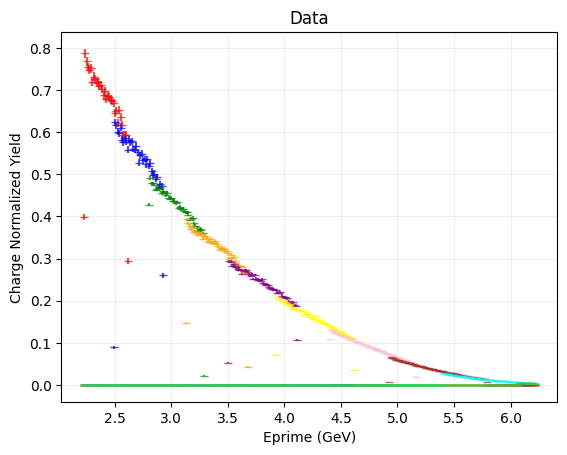

In [4]:
#Define the data cuts
data_cut = "-8 < H_gtr_dp && H_gtr_dp < 8 && H_cal_etottracknorm > 0.7 && abs(H_gtr_ph) < 0.032 && abs(H_gtr_th) < 0.085 && H_cer_npeSum > 2 && H_bcm_CurrentFlag == 1"

target_dict_name = f'{ntg}_dict'
target_dict = globals()[target_dict_name]
histograms = {}

for momentum in dmom:
    # print("momentum", momentum)
    #Create a TChain
    ch = r.TChain("T")

    for run in target_dict[momentum]:
        ch.Add(f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
    prod_scale = read_report(momentum, ntg)
    #Apply the cuts to the chained dataframe
    hc = df.Filter(data_cut)\
            .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    
    #Create the histograms from the dataframe
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    heprime.Scale(prod_scale)
    heprime_th = heprime.GetValue()
    histograms[momentum] = heprime_th.Clone()

#fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
eprime_bin_centers_2p42, eprime_bin_contents_2p42, eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
eprime_bin_centers_2p71, eprime_bin_contents_2p71, eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
eprime_bin_centers_3p04, eprime_bin_contents_3p04, eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
eprime_bin_centers_3p4, eprime_bin_contents_3p4, eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
eprime_bin_centers_3p81, eprime_bin_contents_3p81, eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
eprime_bin_centers_4p27, eprime_bin_contents_4p27, eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
eprime_bin_centers_4p78, eprime_bin_contents_4p78, eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
eprime_bin_centers_5p36, eprime_bin_contents_5p36, eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
eprime_bin_centers_5p878, eprime_bin_contents_5p878, eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
eprime_bin_centers_6p6, eprime_bin_contents_6p6, eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

prod_scale_2p42 = read_report(2.42, ntg)
prod_scale_2p71 = read_report(2.71, ntg)
prod_scale_3p04 = read_report(3.04, ntg)
prod_scale_3p4 = read_report(3.4, ntg)
prod_scale_3p81 = read_report(3.81, ntg)
prod_scale_4p27 = read_report(4.27, ntg)
prod_scale_4p78 = read_report(4.78, ntg)
prod_scale_5p36 = read_report(5.36, ntg)
prod_scale_5p878 = read_report(5.878, ntg)
prod_scale_6p6 = read_report(6.6, ntg)

#Perform charge symmetric background subtraction
csb_contents_2p42 = csb(eprime_bin_centers_2p42[eprime_bin_contents_2p42 != 0], ntg, dang)
csb_contents_2p71 = csb(eprime_bin_centers_2p71[eprime_bin_contents_2p71 != 0], ntg, dang)
csb_contents_3p04 = csb(eprime_bin_centers_3p04[eprime_bin_contents_3p04 != 0], ntg, dang)
csb_contents_3p4 = csb(eprime_bin_centers_3p4[eprime_bin_contents_3p4 != 0], ntg, dang)
csb_contents_3p81 = csb(eprime_bin_centers_3p81[eprime_bin_contents_3p81 != 0], ntg, dang)
csb_contents_4p27 = csb(eprime_bin_centers_4p27[eprime_bin_contents_4p27 != 0], ntg, dang)
csb_contents_4p78 = csb(eprime_bin_centers_4p78[eprime_bin_contents_4p78 != 0], ntg, dang)
csb_contents_5p36 = csb(eprime_bin_centers_5p36[eprime_bin_contents_5p36 != 0], ntg, dang)
csb_contents_5p878 = csb(eprime_bin_centers_5p878[eprime_bin_contents_5p878 != 0], ntg, dang)
csb_contents_6p6 = csb(eprime_bin_centers_6p6[eprime_bin_contents_6p6 != 0], ntg, dang)

print("non zero indices of eprime_bin_contents_2p71", np.nonzero(eprime_bin_contents_2p71)[0])
# print("ep_bin_contents_2p71", eprime_bin_contents_2p71)

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(eprime_bin_contents_2p42)
subtracted_bin_contents_2p71 = np.array(eprime_bin_contents_2p71)
subtracted_bin_contents_3p04 = np.array(eprime_bin_contents_3p04)
subtracted_bin_contents_3p4 = np.array(eprime_bin_contents_3p4)
subtracted_bin_contents_3p81 = np.array(eprime_bin_contents_3p81)
subtracted_bin_contents_4p27 = np.array(eprime_bin_contents_4p27)
subtracted_bin_contents_4p78 = np.array(eprime_bin_contents_4p78)
subtracted_bin_contents_5p36 = np.array(eprime_bin_contents_5p36)
subtracted_bin_contents_5p878 = np.array(eprime_bin_contents_5p878)
subtracted_bin_contents_6p6 = np.array(eprime_bin_contents_6p6)

# Find non-zero indices
# [0] is used to get the first element of the tuple returned by np.nonzero
non_zero_indices_2p42 = np.nonzero(eprime_bin_contents_2p42)[0]
non_zero_indices_2p71 = np.nonzero(eprime_bin_contents_2p71)[0]
non_zero_indices_3p04 = np.nonzero(eprime_bin_contents_3p04)[0]
non_zero_indices_3p4 = np.nonzero(eprime_bin_contents_3p4)[0]
non_zero_indices_3p81 = np.nonzero(eprime_bin_contents_3p81)[0]
non_zero_indices_4p27 = np.nonzero(eprime_bin_contents_4p27)[0]
non_zero_indices_4p78 = np.nonzero(eprime_bin_contents_4p78)[0]
non_zero_indices_5p36 = np.nonzero(eprime_bin_contents_5p36)[0]
non_zero_indices_5p878 = np.nonzero(eprime_bin_contents_5p878)[0]
non_zero_indices_6p6 = np.nonzero(eprime_bin_contents_6p6)[0]

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
# Perform the subtraction only at non-zero indices
    subtracted_bin_contents_2p42[non_zero_indices_2p42] -= csb_contents_2p42 * prod_scale_2p42
    subtracted_bin_contents_2p71[non_zero_indices_2p71] -= csb_contents_2p71 * prod_scale_2p71
    subtracted_bin_contents_3p04[non_zero_indices_3p04] -= csb_contents_3p04 * prod_scale_3p04
    subtracted_bin_contents_3p4[non_zero_indices_3p4] -= csb_contents_3p4 * prod_scale_3p4
    subtracted_bin_contents_3p81[non_zero_indices_3p81] -= csb_contents_3p81 * prod_scale_3p81
    subtracted_bin_contents_4p27[non_zero_indices_4p27] -= csb_contents_4p27 * prod_scale_4p27
    subtracted_bin_contents_4p78[non_zero_indices_4p78] -= csb_contents_4p78 * prod_scale_4p78
    subtracted_bin_contents_5p36[non_zero_indices_5p36] -= csb_contents_5p36 * prod_scale_5p36
    subtracted_bin_contents_5p878[non_zero_indices_5p878] -= csb_contents_5p878 * prod_scale_5p878
    subtracted_bin_contents_6p6[non_zero_indices_6p6] -= csb_contents_6p6 * prod_scale_6p6
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

# Initialize the resulting array with the original errors
subtracted_bin_errors_2p42 = np.array(eprime_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(eprime_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(eprime_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(eprime_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(eprime_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(eprime_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(eprime_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(eprime_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(eprime_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(eprime_bin_errors_6p6)

# Add the errors in quadrature
if len(non_zero_indices_2p71) == len(csb_contents_2p71):
    subtracted_bin_errors_2p42[non_zero_indices_2p42] = np.sqrt(subtracted_bin_errors_2p42[non_zero_indices_2p42]**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
    subtracted_bin_errors_2p71[non_zero_indices_2p71] = np.sqrt(subtracted_bin_errors_2p71[non_zero_indices_2p71]**2 + (csb_contents_2p71 * prod_scale)**2)
    subtracted_bin_errors_3p04[non_zero_indices_3p04] = np.sqrt(subtracted_bin_errors_3p04[non_zero_indices_3p04]**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
    subtracted_bin_errors_3p4[non_zero_indices_3p4] = np.sqrt(subtracted_bin_errors_3p4[non_zero_indices_3p4]**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
    subtracted_bin_errors_3p81[non_zero_indices_3p81] = np.sqrt(subtracted_bin_errors_3p81[non_zero_indices_3p81]**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
    subtracted_bin_errors_4p27[non_zero_indices_4p27] = np.sqrt(subtracted_bin_errors_4p27[non_zero_indices_4p27]**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
    subtracted_bin_errors_4p78[non_zero_indices_4p78] = np.sqrt(subtracted_bin_errors_4p78[non_zero_indices_4p78]**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
    subtracted_bin_errors_5p36[non_zero_indices_5p36] = np.sqrt(subtracted_bin_errors_5p36[non_zero_indices_5p36]**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
    subtracted_bin_errors_5p878[non_zero_indices_5p878] = np.sqrt(subtracted_bin_errors_5p878[non_zero_indices_5p878]**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
    subtracted_bin_errors_6p6[non_zero_indices_6p6] = np.sqrt(subtracted_bin_errors_6p6[non_zero_indices_6p6]**2 + (csb_contents_6p6 * prod_scale_6p6)**2)
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

ax.errorbar(eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
ax.errorbar(eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax.errorbar(eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax.errorbar(eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax.errorbar(eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax.errorbar(eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax.errorbar(eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax.errorbar(eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax.errorbar(eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax.errorbar(eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
ax.set_xlabel('Eprime (GeV)')
ax.set_ylabel('Charge Normalized Yield')
ax.set_title('Data')
ax.grid(alpha = 0.2)

# Check if IMT is enabled
if r.IsImplicitMTEnabled():
    nthreads = r.ROOT.GetThreadPoolSize()
    print(f"Implicit multithreading is enabled, using {nthreads} cores.")
else:
    print("Implicit MT is not enabled.")

<ErrorbarContainer object of 3 artists>

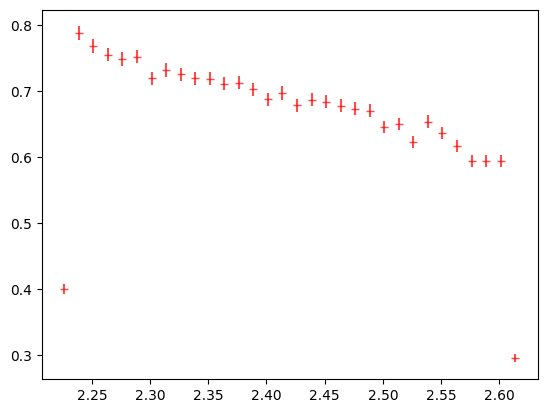

In [5]:
figt1, axt1 = plt.subplots()
axt1.errorbar(eprime_bin_centers_2p42[subtracted_bin_contents_2p42 != 0], subtracted_bin_contents_2p42[subtracted_bin_contents_2p42 != 0], yerr = subtracted_bin_errors_2p42[subtracted_bin_contents_2p42 != 0], fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')

<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [6]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_20deg{nsimstring}22_hms.out")

#Fixing the binning for the simulation histograms
hseprime_min = bin_eprime_low
hseprime_max = bin_eprime_high
hseprime_num_bins = bin_num
hseprime_binwidth = (hseprime_max - hseprime_min) / hseprime_num_bins
hseprime_binedges = np.linspace(hseprime_min, hseprime_max, hseprime_num_bins + 1)

Eprime_dict = {}
Eprime_dicti = {}
xsec_array = {}
mc_scale = {}
for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{nsimstring}_20degm{string}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)

    # New delta correction
    # Perform the delta correction
    electrons["hsdelta"] = (0.990337 * electrons["hsdelta"]) - 0.00236077 * (electrons["hsdelta"]**2) + 0.000286814 * (electrons["hsdelta"]**3) + 2.09878E-6 * (electrons["hsdelta"]**4) - 2.48674E-6 * (electrons["hsdelta"]**5) + 1.8646E-7 * (electrons["hsdelta"]**6)


    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    # Calculate E' and theta (in degrees)
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts)/np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method = 'linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation
    # print(f"MC Scale for {momentum} GeV:", mc_scale[momentum])

#This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_counts_eprime_2p42, bin_edges_eprime_2p42 = np.histogram(Eprime_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hseprime_binedges)
bin_counts_eprime_2p71, bin_edges_eprime_2p71 = np.histogram(Eprime_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hseprime_binedges)
bin_counts_eprime_3p04, bin_edges_eprime_3p04 = np.histogram(Eprime_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hseprime_binedges)
bin_counts_eprime_3p4, bin_edges_eprime_3p4 = np.histogram(Eprime_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hseprime_binedges)
bin_counts_eprime_3p81, bin_edges_eprime_3p81 = np.histogram(Eprime_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hseprime_binedges)
bin_counts_eprime_4p27, bin_edges_eprime_4p27 = np.histogram(Eprime_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hseprime_binedges)
bin_counts_eprime_4p78, bin_edges_eprime_4p78 = np.histogram(Eprime_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hseprime_binedges)
bin_counts_eprime_5p36, bin_edges_eprime_5p36 = np.histogram(Eprime_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hseprime_binedges)
bin_counts_eprime_5p878, bin_edges_eprime_5p878 = np.histogram(Eprime_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hseprime_binedges)
bin_counts_eprime_6p6, bin_edges_eprime_6p6 = np.histogram(Eprime_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hseprime_binedges)

#bin_sqares contains the square of the error for each bin
bin_squares_eprime_2p42, _ = np.histogram(Eprime_dict[2.42], weights = (xsec_array[2.42] * mc_scale[2.42])**2, bins = hseprime_binedges)
bin_squares_eprime_2p71, _ = np.histogram(Eprime_dict[2.71], weights = (xsec_array[2.71] * mc_scale[2.71])**2, bins = hseprime_binedges)
bin_squares_eprime_3p04, _ = np.histogram(Eprime_dict[3.04], weights = (xsec_array[3.04] * mc_scale[3.04])**2, bins = hseprime_binedges)
bin_squares_eprime_3p4, _ = np.histogram(Eprime_dict[3.4], weights = (xsec_array[3.4] * mc_scale[3.4])**2, bins = hseprime_binedges)
bin_squares_eprime_3p81, _ = np.histogram(Eprime_dict[3.81], weights = (xsec_array[3.81] * mc_scale[3.81])**2, bins = hseprime_binedges)
bin_squares_eprime_4p27, _ = np.histogram(Eprime_dict[4.27], weights = (xsec_array[4.27] * mc_scale[4.27])**2, bins = hseprime_binedges)
bin_squares_eprime_4p78, _ = np.histogram(Eprime_dict[4.78], weights = (xsec_array[4.78] * mc_scale[4.78])**2, bins = hseprime_binedges)
bin_squares_eprime_5p36, _ = np.histogram(Eprime_dict[5.36], weights = (xsec_array[5.36] * mc_scale[5.36])**2, bins = hseprime_binedges)
bin_squares_eprime_5p878, _ = np.histogram(Eprime_dict[5.878], weights = (xsec_array[5.878] * mc_scale[5.878])**2, bins = hseprime_binedges)
bin_squares_eprime_6p6, _ = np.histogram(Eprime_dict[6.6], weights = (xsec_array[6.6] * mc_scale[6.6])**2, bins = hseprime_binedges)

#Calculating the actual error for each bin
bin_errors_eprime_2p42 = np.sqrt(bin_squares_eprime_2p42)
bin_errors_eprime_2p71 = np.sqrt(bin_squares_eprime_2p71)
bin_errors_eprime_3p04 = np.sqrt(bin_squares_eprime_3p04)
bin_errors_eprime_3p4 = np.sqrt(bin_squares_eprime_3p4)
bin_errors_eprime_3p81 = np.sqrt(bin_squares_eprime_3p81)
bin_errors_eprime_4p27 = np.sqrt(bin_squares_eprime_4p27)
bin_errors_eprime_4p78 = np.sqrt(bin_squares_eprime_4p78)
bin_errors_eprime_5p36 = np.sqrt(bin_squares_eprime_5p36)
bin_errors_eprime_5p878 = np.sqrt(bin_squares_eprime_5p878)
bin_errors_eprime_6p6 = np.sqrt(bin_squares_eprime_6p6)

#The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
bin_centers_eprime_2p42 = (bin_edges_eprime_2p42[:-1] + bin_edges_eprime_2p42[1:]) / 2
bin_centers_eprime_2p71 = (bin_edges_eprime_2p71[:-1] + bin_edges_eprime_2p71[1:]) / 2
bin_centers_eprime_3p04 = (bin_edges_eprime_3p04[:-1] + bin_edges_eprime_3p04[1:]) / 2
bin_centers_eprime_3p4 = (bin_edges_eprime_3p4[:-1] + bin_edges_eprime_3p4[1:]) / 2
bin_centers_eprime_3p81 = (bin_edges_eprime_3p81[:-1] + bin_edges_eprime_3p81[1:]) / 2
bin_centers_eprime_4p27 = (bin_edges_eprime_4p27[:-1] + bin_edges_eprime_4p27[1:]) / 2
bin_centers_eprime_4p78 = (bin_edges_eprime_4p78[:-1] + bin_edges_eprime_4p78[1:]) / 2
bin_centers_eprime_5p36 = (bin_edges_eprime_5p36[:-1] + bin_edges_eprime_5p36[1:]) / 2
bin_centers_eprime_5p878 = (bin_edges_eprime_5p878[:-1] + bin_edges_eprime_5p878[1:]) / 2
bin_centers_eprime_6p6 = (bin_edges_eprime_6p6[:-1] + bin_edges_eprime_6p6[1:]) / 2

#Plotting the histogram with error bars
ax.errorbar(bin_centers_eprime_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax.errorbar(bin_centers_eprime_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax.errorbar(bin_centers_eprime_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.04 GeV')
ax.errorbar(bin_centers_eprime_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.4 GeV')
ax.errorbar(bin_centers_eprime_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.81 GeV')
ax.errorbar(bin_centers_eprime_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.27 GeV')
ax.errorbar(bin_centers_eprime_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.78 GeV')
ax.errorbar(bin_centers_eprime_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.36 GeV')
ax.errorbar(bin_centers_eprime_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.878 GeV')
ax.errorbar(bin_centers_eprime_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 6.6 GeV')
ax.grid(True, alpha = 0.2)
ax.set_xlabel('Eprime')
ax.set_ylabel('Simulation Yield')
ax.set_yscale('log')
# ax.legend() 
ax.set_title(f'{ntg}@{dang}˚ Simulation')
fig.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

# Fix this binning issue

Text(0, 0.5, 'Simulation Yield')

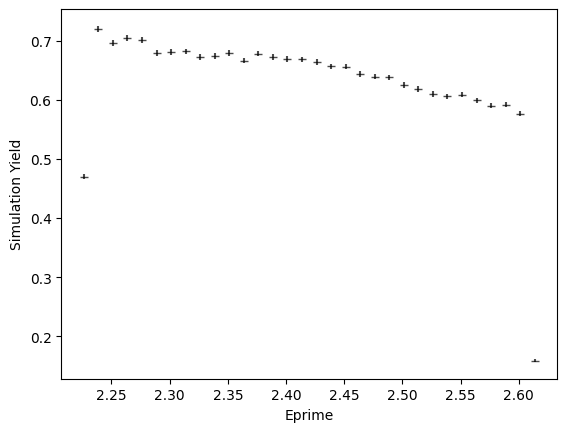

In [7]:
fig13, ax13 = plt.subplots()
ax13.errorbar(bin_centers_eprime_2p42[bin_counts_eprime_2p42 != 0], bin_counts_eprime_2p42[bin_counts_eprime_2p42 != 0], yerr = bin_errors_eprime_2p42[bin_counts_eprime_2p42 != 0], fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax13.set_xlabel('Eprime')
ax13.set_ylabel('Simulation Yield')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1941147541.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1941147541.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1941147541.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1941147541.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1941147541.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p4 = eprime_bin_contents_3p4/bin

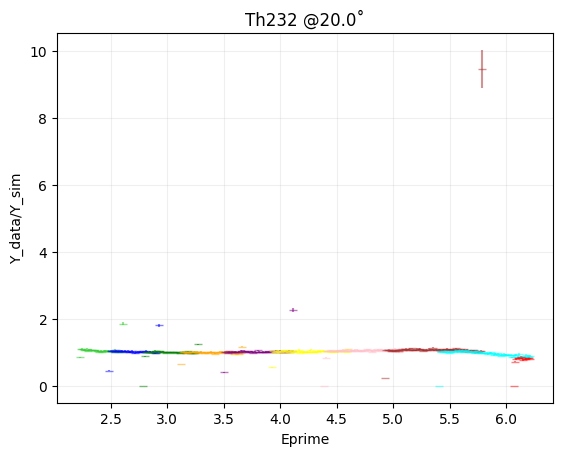

In [8]:
ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_counts_eprime_3p4
ratio_eprime_3p81 = eprime_bin_contents_3p81/bin_counts_eprime_3p81
ratio_eprime_4p27 = eprime_bin_contents_4p27/bin_counts_eprime_4p27
ratio_eprime_4p78 = eprime_bin_contents_4p78/bin_counts_eprime_4p78
ratio_eprime_5p36 = eprime_bin_contents_5p36/bin_counts_eprime_5p36
ratio_eprime_5p878 = eprime_bin_contents_5p878/bin_counts_eprime_5p878
ratio_eprime_6p6 = eprime_bin_contents_6p6/bin_counts_eprime_6p6

ratio_errors_2p42 = ratio_eprime_2p42 * np.sqrt((eprime_bin_errors_2p42/eprime_bin_contents_2p42)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)
ratio_errors_2p71 = ratio_eprime_2p71 * np.sqrt((eprime_bin_errors_2p71/eprime_bin_contents_2p71)**2 + (bin_errors_eprime_2p71/bin_counts_eprime_2p71)**2)
ratio_errors_3p04 = ratio_eprime_3p04 * np.sqrt((eprime_bin_errors_3p04/eprime_bin_contents_3p04)**2 + (bin_errors_eprime_3p04/bin_counts_eprime_3p04)**2)
ratio_errors_3p4 = ratio_eprime_3p4 * np.sqrt((eprime_bin_errors_3p4/eprime_bin_contents_3p4)**2 + (bin_errors_eprime_3p4/bin_counts_eprime_3p4)**2)
ratio_errors_3p81 = ratio_eprime_3p81 * np.sqrt((eprime_bin_errors_3p81/eprime_bin_contents_3p81)**2 + (bin_errors_eprime_3p81/bin_counts_eprime_3p81)**2)
ratio_errors_4p27 = ratio_eprime_4p27 * np.sqrt((eprime_bin_errors_4p27/eprime_bin_contents_4p27)**2 + (bin_errors_eprime_4p27/bin_counts_eprime_4p27)**2)
ratio_errors_4p78 = ratio_eprime_4p78 * np.sqrt((eprime_bin_errors_4p78/eprime_bin_contents_4p78)**2 + (bin_errors_eprime_4p78/bin_counts_eprime_4p78)**2)
ratio_errors_5p36 = ratio_eprime_5p36 * np.sqrt((eprime_bin_errors_5p36/eprime_bin_contents_5p36)**2 + (bin_errors_eprime_5p36/bin_counts_eprime_5p36)**2)
ratio_errors_5p878 = ratio_eprime_5p878 * np.sqrt((eprime_bin_errors_5p878/eprime_bin_contents_5p878)**2 + (bin_errors_eprime_5p878/bin_counts_eprime_5p878)**2)
ratio_errors_6p6 = ratio_eprime_6p6 * np.sqrt((eprime_bin_errors_6p6/eprime_bin_contents_6p6)**2 + (bin_errors_eprime_6p6/bin_counts_eprime_6p6)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(bin_centers_eprime_2p42, ratio_eprime_2p42, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.5, color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(bin_centers_eprime_2p71, ratio_eprime_2p71, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.5, color = 'blue', label = '2.71 GeV')
ax2.errorbar(bin_centers_eprime_3p04, ratio_eprime_3p04, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.5, color = 'green', label = '3.04 GeV')
ax2.errorbar(bin_centers_eprime_3p4, ratio_eprime_3p4, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.5, color = 'orange', label = '3.4 GeV')
ax2.errorbar(bin_centers_eprime_3p81, ratio_eprime_3p81, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.5, color = 'purple', label = '3.81 GeV')
ax2.errorbar(bin_centers_eprime_4p27, ratio_eprime_4p27, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.5, color = 'yellow', label = '4.27 GeV')
ax2.errorbar(bin_centers_eprime_4p78, ratio_eprime_4p78, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.5, color = 'pink', label = '4.78 GeV')
ax2.errorbar(bin_centers_eprime_5p36, ratio_eprime_5p36, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.5, color = 'brown', label = '5.36 GeV')
ax2.errorbar(bin_centers_eprime_5p878, ratio_eprime_5p878, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.5, color = 'cyan', label = '5.878 GeV')
ax2.errorbar(bin_centers_eprime_6p6, ratio_eprime_6p6, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.5, color = 'red', label = '6.6 GeV')
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Y_data/Y_sim')
ax2.set_title(f'{ntg} @{dang}˚')
ax2.grid(True, alpha = 0.2)
ax.set_ylim(0.9,1.1)
fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{start_time:.0f}.pdf')

<ErrorbarContainer object of 3 artists>

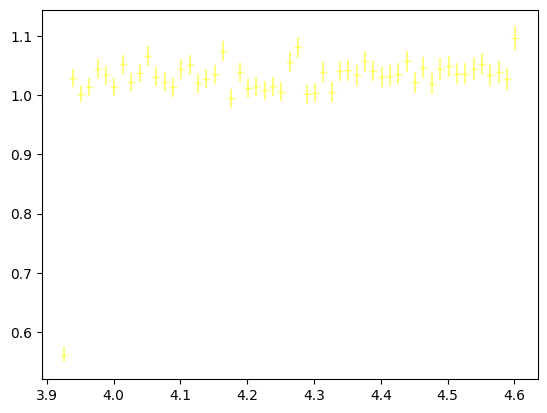

In [9]:
fig11, ax11 = plt.subplots()
ax11.errorbar(bin_centers_eprime_4p27, ratio_eprime_4p27, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.5, color = 'yellow', label = '4.27 GeV')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


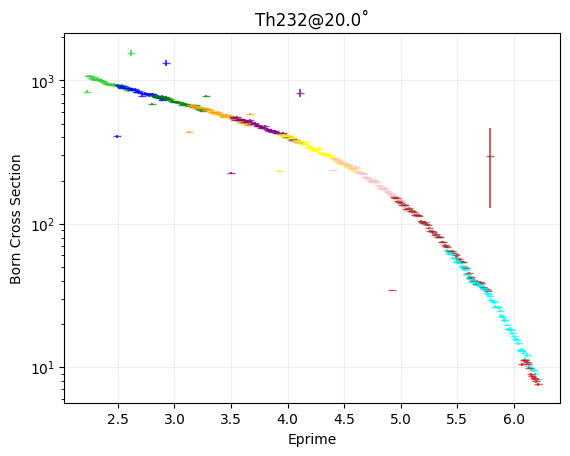

In [10]:
# Get points to interpolate based on angle and E'
points_to_interpolate_2p42 = np.column_stack((bin_centers_eprime_2p42, np.full(len(bin_centers_eprime_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((bin_centers_eprime_2p71, np.full(len(bin_centers_eprime_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((bin_centers_eprime_3p04, np.full(len(bin_centers_eprime_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((bin_centers_eprime_3p4, np.full(len(bin_centers_eprime_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((bin_centers_eprime_3p81, np.full(len(bin_centers_eprime_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((bin_centers_eprime_4p27, np.full(len(bin_centers_eprime_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((bin_centers_eprime_4p78, np.full(len(bin_centers_eprime_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((bin_centers_eprime_5p36, np.full(len(bin_centers_eprime_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((bin_centers_eprime_5p878, np.full(len(bin_centers_eprime_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((bin_centers_eprime_6p6, np.full(len(bin_centers_eprime_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42 = griddata(points, V6, points_to_interpolate_2p42, method='linear')
born_xsec_array_2p71 = griddata(points, V6, points_to_interpolate_2p71, method='linear')
born_xsec_array_3p04 = griddata(points, V6, points_to_interpolate_3p04, method='linear')
born_xsec_array_3p4 = griddata(points, V6, points_to_interpolate_3p4, method='linear')
born_xsec_array_3p81 = griddata(points, V6, points_to_interpolate_3p81, method='linear')
born_xsec_array_4p27 = griddata(points, V6, points_to_interpolate_4p27, method='linear')
born_xsec_array_4p78 = griddata(points, V6, points_to_interpolate_4p78, method='linear')
born_xsec_array_5p36 = griddata(points, V6, points_to_interpolate_5p36, method='linear')
born_xsec_array_5p878 = griddata(points, V6, points_to_interpolate_5p878, method='linear')
born_xsec_array_6p6 = griddata(points, V6, points_to_interpolate_6p6, method='linear')
# print("Length of born_xsec_array", len(born_xsec_array))

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42 = griddata(points, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71 = griddata(points, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04 = griddata(points, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4 = griddata(points, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81 = griddata(points, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27 = griddata(points, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78 = griddata(points, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36 = griddata(points, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878 = griddata(points, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6 = griddata(points, V13, points_to_interpolate_6p6, method = 'linear')

fig3, ax3 = plt.subplots()
# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_ntg = ratio_eprime_2p42 * born_xsec_array_2p42 * ccf_2p42
born_cross_2p71_ntg = ratio_eprime_2p71 * born_xsec_array_2p71 * ccf_2p71
born_cross_3p04_ntg = ratio_eprime_3p04 * born_xsec_array_3p04 * ccf_3p04
born_cross_3p4_ntg= ratio_eprime_3p4 * born_xsec_array_3p4 * ccf_3p4
born_cross_3p81_ntg = ratio_eprime_3p81 * born_xsec_array_3p81 * ccf_3p81
born_cross_4p27_ntg = ratio_eprime_4p27 * born_xsec_array_4p27 * ccf_4p27
born_cross_4p78_ntg = ratio_eprime_4p78 * born_xsec_array_4p78 * ccf_4p78
born_cross_5p36_ntg = ratio_eprime_5p36 * born_xsec_array_5p36 * ccf_5p36
born_cross_5p878_ntg = ratio_eprime_5p878 * born_xsec_array_5p878 * ccf_5p878
born_cross_6p6_ntg= ratio_eprime_6p6 * born_xsec_array_6p6 * ccf_6p6

# print("Length of born_cross", len(born_cross))
# print("Born cross section", born_cross)
born_errors_2p42_ntg = born_cross_2p42_ntg * ratio_errors_2p42
born_errors_2p71_ntg = born_cross_2p71_ntg * ratio_errors_2p71
born_errors_3p04_ntg = born_cross_3p04_ntg * ratio_errors_3p04
born_errors_3p4_ntg = born_cross_3p4_ntg * ratio_errors_3p4
born_errors_3p81_ntg = born_cross_3p81_ntg * ratio_errors_3p81
born_errors_4p27_ntg = born_cross_4p27_ntg * ratio_errors_4p27
born_errors_4p78_ntg = born_cross_4p78_ntg * ratio_errors_4p78
born_errors_5p36_ntg = born_cross_5p36_ntg * ratio_errors_5p36
born_errors_5p878_ntg = born_cross_5p878_ntg * ratio_errors_5p878
born_errors_6p6_ntg = born_cross_6p6_ntg * ratio_errors_6p6

ax3.errorbar(bin_centers_eprime_2p42, born_cross_2p42_ntg, yerr = born_errors_2p42_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax3.errorbar(bin_centers_eprime_2p71, born_cross_2p71_ntg, yerr = born_errors_2p71_ntg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax3.errorbar(bin_centers_eprime_3p04, born_cross_3p04_ntg, yerr = born_errors_3p04_ntg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax3.errorbar(bin_centers_eprime_3p4, born_cross_3p4_ntg, yerr = born_errors_3p4_ntg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax3.errorbar(bin_centers_eprime_3p81, born_cross_3p81_ntg, yerr = born_errors_3p81_ntg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax3.errorbar(bin_centers_eprime_4p27, born_cross_4p27_ntg, yerr = born_errors_4p27_ntg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax3.errorbar(bin_centers_eprime_4p78, born_cross_4p78_ntg, yerr = born_errors_4p78_ntg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax3.errorbar(bin_centers_eprime_5p36, born_cross_5p36_ntg, yerr = born_errors_5p36_ntg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax3.errorbar(bin_centers_eprime_5p878, born_cross_5p878_ntg, yerr = born_errors_5p878_ntg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax3.errorbar(bin_centers_eprime_6p6, born_cross_6p6_ntg, yerr = born_errors_6p6_ntg, fmt = '_', alpha = 0.7, color = 'red', label = '6.6 GeV')
ax3.set_xlabel('Eprime')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{dang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(True, alpha = 0.2)
fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


In [11]:
Z, A = 13, 27 #Target
thick = 0.24 #Target thickness in g/cm^2
E = 0.19535 #Ratio of dummy to target cell thickness
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

for momentum in dmom:
    ch = r.TChain("T")
    for run in Dummy_dict[momentum]:
        ch.Add(f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)
    prod_scale = read_report(momentum, ald)
    hc = df.Filter(data_cut)\
            .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    heprime.Scale(prod_scale)
    heprime_th = heprime.GetValue()
    histograms[momentum] = heprime_th.Clone()


_, dummy_eprime_bin_contents_2p42, dummy_eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
_, dummy_eprime_bin_contents_2p71, dummy_eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
_, dummy_eprime_bin_contents_3p04, dummy_eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
_, dummy_eprime_bin_contents_3p4, dummy_eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
_, dummy_eprime_bin_contents_3p81, dummy_eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
_, dummy_eprime_bin_contents_4p27, dummy_eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
_, dummy_eprime_bin_contents_4p78, dummy_eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
_, dummy_eprime_bin_contents_5p36, dummy_eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
_, dummy_eprime_bin_contents_5p878, dummy_eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
_, dummy_eprime_bin_contents_6p6, dummy_eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy
Target dictionary found for Dummy


<h1 align="center">DATA WORK FOR DTG</h1>


Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
Target dictionary found for LD2
non zero indices of eprime_bin_contents_2p71 [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56]


<ErrorbarContainer object of 3 artists>

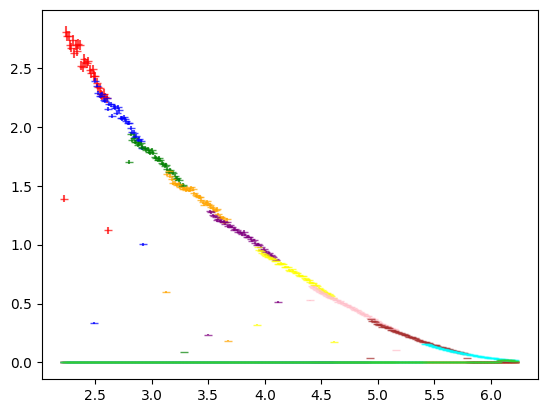

In [14]:
#Kinematic variables
Z, A = target_info[dtg][0], target_info[dtg][1]  #Target
thick = target_info[dtg][2] #g/cm2. From Cameron's target sheet column 'R'
thick = thick * 0.996 #Cryo target contraction correction factor
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
ytar = {}
ytar_hist = {}
for momentum in dmom:
    # print("momentum", momentum)
    #Create a TChain
    ch = r.TChain("T")

    for run in LD2_dict[momentum]:
        ch.Add(f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
    prod_scale = read_report(momentum, dtg)
    #Apply the cuts to the chained dataframe
    hc = df.Filter(data_cut)\
        .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    
    #Create the histograms from the dataframe
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    hdeltadat = hc.Histo1D(("Delta", "Delta", bin_num, -8.0, 8.0), "H_gtr_dp")
    hdeltadat.Sumw2()
    # hytar = hc.Histo1D(("hytar", "hytar", 100, -5.0, 5.0), "H_gtr_ytar")
    # hytar.Sumw2()
    # print("Total entries in data histogram", heprime.GetEntries())
    heprime.Scale(prod_scale)
    # hytar.Scale(prod_scale)
    # print(f"prod_scale for {momentum} GeV", prod_scale)
    # print(type(heprime),"heprime type")
    heprime_th = heprime.GetValue()
    # hytar_th = hytar.GetValue()
    histograms[momentum] = heprime_th.Clone()
    # ytar_hist[momentum] = hytar_th.GetValue()

fig4, ax4 = plt.subplots()
eprime_bin_centers_2p42, eprime_bin_contents_2p42, eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
eprime_bin_centers_2p71, eprime_bin_contents_2p71, eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
eprime_bin_centers_3p04, eprime_bin_contents_3p04, eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
eprime_bin_centers_3p4, eprime_bin_contents_3p4, eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
eprime_bin_centers_3p81, eprime_bin_contents_3p81, eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
eprime_bin_centers_4p27, eprime_bin_contents_4p27, eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
eprime_bin_centers_4p78, eprime_bin_contents_4p78, eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
eprime_bin_centers_5p36, eprime_bin_contents_5p36, eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
eprime_bin_centers_5p878, eprime_bin_contents_5p878, eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
eprime_bin_centers_6p6, eprime_bin_contents_6p6, eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

# ytar_bin_centers_2p42, ytar_bin_contents_2p42, ytar_bin_errors_2p42 = root_hist_to_numpy(ytar_hist[2.42])

# Perform Dummy Subtraction
eprime_bin_contents_2p42 = eprime_bin_contents_2p42 - E * dummy_eprime_bin_contents_2p42
eprime_bin_contents_2p71 = eprime_bin_contents_2p71 - E * dummy_eprime_bin_contents_2p71
eprime_bin_contents_3p04 = eprime_bin_contents_3p04 - E * dummy_eprime_bin_contents_3p04
eprime_bin_contents_3p4 = eprime_bin_contents_3p4 - E * dummy_eprime_bin_contents_3p4
eprime_bin_contents_3p81 = eprime_bin_contents_3p81 - E * dummy_eprime_bin_contents_3p81
eprime_bin_contents_4p27 = eprime_bin_contents_4p27 - E * dummy_eprime_bin_contents_4p27
eprime_bin_contents_4p78 = eprime_bin_contents_4p78 - E * dummy_eprime_bin_contents_4p78
eprime_bin_contents_5p36 = eprime_bin_contents_5p36 - E * dummy_eprime_bin_contents_5p36
eprime_bin_contents_5p878 = eprime_bin_contents_5p878 - E * dummy_eprime_bin_contents_5p878
eprime_bin_contents_6p6 = eprime_bin_contents_6p6 - E * dummy_eprime_bin_contents_6p6

#Error Prpoagation
eprime_bin_errors_2p42 = np.sqrt((eprime_bin_errors_2p42)**2 + (dummy_eprime_bin_errors_2p42)**2)
eprime_bin_errors_2p71 = np.sqrt((eprime_bin_errors_2p71)**2 + (dummy_eprime_bin_errors_2p71)**2)
eprime_bin_errors_3p04 = np.sqrt((eprime_bin_errors_3p04)**2 + (dummy_eprime_bin_errors_3p04)**2)
eprime_bin_errors_3p4 = np.sqrt((eprime_bin_errors_3p4)**2 + (dummy_eprime_bin_errors_3p4)**2)
eprime_bin_errors_3p81 = np.sqrt((eprime_bin_errors_3p81)**2 + (dummy_eprime_bin_errors_3p81)**2)
eprime_bin_errors_4p27 = np.sqrt((eprime_bin_errors_4p27)**2 + (dummy_eprime_bin_errors_4p27)**2)
eprime_bin_errors_4p78 = np.sqrt((eprime_bin_errors_4p78)**2 + (dummy_eprime_bin_errors_4p78)**2)
eprime_bin_errors_5p36 = np.sqrt((eprime_bin_errors_5p36)**2 + (dummy_eprime_bin_errors_5p36)**2)
eprime_bin_errors_5p878 = np.sqrt((eprime_bin_errors_5p878)**2 + (dummy_eprime_bin_errors_5p878)**2)
eprime_bin_errors_6p6 = np.sqrt((eprime_bin_errors_6p6)**2 + (dummy_eprime_bin_errors_6p6)**2)

prod_scale_2p42 = read_report(2.42, dtg)
prod_scale_2p71 = read_report(2.71, dtg)
prod_scale_3p04 = read_report(3.04, dtg)
prod_scale_3p4 = read_report(3.4, dtg)
prod_scale_3p81 = read_report(3.81, dtg)
prod_scale_4p27 = read_report(4.27, dtg)
prod_scale_4p78 = read_report(4.78, dtg)
prod_scale_5p36 = read_report(5.36, dtg)
prod_scale_5p878 = read_report(5.878, dtg)
prod_scale_6p6 = read_report(6.6, dtg)

#Perform charge symmetric background subtraction
csb_contents_2p42 = csb(eprime_bin_centers_2p42[eprime_bin_contents_2p42 != 0], dtg, dang)
csb_contents_2p71 = csb(eprime_bin_centers_2p71[eprime_bin_contents_2p71 != 0], dtg, dang)
csb_contents_3p04 = csb(eprime_bin_centers_3p04[eprime_bin_contents_3p04 != 0], dtg, dang)
csb_contents_3p4 = csb(eprime_bin_centers_3p4[eprime_bin_contents_3p4 != 0], dtg, dang)
csb_contents_3p81 = csb(eprime_bin_centers_3p81[eprime_bin_contents_3p81 != 0], dtg, dang)
csb_contents_4p27 = csb(eprime_bin_centers_4p27[eprime_bin_contents_4p27 != 0], dtg, dang)
csb_contents_4p78 = csb(eprime_bin_centers_4p78[eprime_bin_contents_4p78 != 0], dtg, dang)
csb_contents_5p36 = csb(eprime_bin_centers_5p36[eprime_bin_contents_5p36 != 0], dtg, dang)
csb_contents_5p878 = csb(eprime_bin_centers_5p878[eprime_bin_contents_5p878 != 0], dtg, dang)
csb_contents_6p6 = csb(eprime_bin_centers_6p6[eprime_bin_contents_6p6 != 0], dtg, dang)

print("non zero indices of eprime_bin_contents_2p71", np.nonzero(eprime_bin_contents_2p71)[0])

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(eprime_bin_contents_2p42)
subtracted_bin_contents_2p71 = np.array(eprime_bin_contents_2p71)
subtracted_bin_contents_3p04 = np.array(eprime_bin_contents_3p04)
subtracted_bin_contents_3p4 = np.array(eprime_bin_contents_3p4)
subtracted_bin_contents_3p81 = np.array(eprime_bin_contents_3p81)
subtracted_bin_contents_4p27 = np.array(eprime_bin_contents_4p27)
subtracted_bin_contents_4p78 = np.array(eprime_bin_contents_4p78)
subtracted_bin_contents_5p36 = np.array(eprime_bin_contents_5p36)
subtracted_bin_contents_5p878 = np.array(eprime_bin_contents_5p878)
subtracted_bin_contents_6p6 = np.array(eprime_bin_contents_6p6)

# Find non-zero indices
non_zero_indices_2p42 = np.nonzero(eprime_bin_contents_2p42)[0]
non_zero_indices_2p71 = np.nonzero(eprime_bin_contents_2p71)[0]
non_zero_indices_3p04 = np.nonzero(eprime_bin_contents_3p04)[0]
non_zero_indices_3p4 = np.nonzero(eprime_bin_contents_3p4)[0]
non_zero_indices_3p81 = np.nonzero(eprime_bin_contents_3p81)[0]
non_zero_indices_4p27 = np.nonzero(eprime_bin_contents_4p27)[0]
non_zero_indices_4p78 = np.nonzero(eprime_bin_contents_4p78)[0]
non_zero_indices_5p36 = np.nonzero(eprime_bin_contents_5p36)[0]
non_zero_indices_5p878 = np.nonzero(eprime_bin_contents_5p878)[0]
non_zero_indices_6p6 = np.nonzero(eprime_bin_contents_6p6)[0]

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
# Perform the subtraction only at non-zero indices
    subtracted_bin_contents_2p42[non_zero_indices_2p42] -= csb_contents_2p42 * prod_scale_2p42
    subtracted_bin_contents_2p71[non_zero_indices_2p71] -= csb_contents_2p71 * prod_scale_2p71
    subtracted_bin_contents_3p04[non_zero_indices_3p04] -= csb_contents_3p04 * prod_scale_3p04
    subtracted_bin_contents_3p4[non_zero_indices_3p4] -= csb_contents_3p4 * prod_scale_3p4
    subtracted_bin_contents_3p81[non_zero_indices_3p81] -= csb_contents_3p81 * prod_scale_3p81
    subtracted_bin_contents_4p27[non_zero_indices_4p27] -= csb_contents_4p27 * prod_scale_4p27
    subtracted_bin_contents_4p78[non_zero_indices_4p78] -= csb_contents_4p78 * prod_scale_4p78
    subtracted_bin_contents_5p36[non_zero_indices_5p36] -= csb_contents_5p36 * prod_scale_5p36
    subtracted_bin_contents_5p878[non_zero_indices_5p878] -= csb_contents_5p878 * prod_scale_5p878
    subtracted_bin_contents_6p6[non_zero_indices_6p6] -= csb_contents_6p6 * prod_scale_6p6
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

subtracted_bin_errors_2p42 = np.array(eprime_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(eprime_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(eprime_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(eprime_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(eprime_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(eprime_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(eprime_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(eprime_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(eprime_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(eprime_bin_errors_6p6)

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
    subtracted_bin_errors_2p42[non_zero_indices_2p42] = np.sqrt(subtracted_bin_errors_2p42[non_zero_indices_2p42]**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
    subtracted_bin_errors_2p71[non_zero_indices_2p71] = np.sqrt(subtracted_bin_errors_2p71[non_zero_indices_2p71]**2 + (csb_contents_2p71 * prod_scale)**2)
    subtracted_bin_errors_3p04[non_zero_indices_3p04] = np.sqrt(subtracted_bin_errors_3p04[non_zero_indices_3p04]**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
    subtracted_bin_errors_3p4[non_zero_indices_3p4] = np.sqrt(subtracted_bin_errors_3p4[non_zero_indices_3p4]**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
    subtracted_bin_errors_3p81[non_zero_indices_3p81] = np.sqrt(subtracted_bin_errors_3p81[non_zero_indices_3p81]**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
    subtracted_bin_errors_4p27[non_zero_indices_4p27] = np.sqrt(subtracted_bin_errors_4p27[non_zero_indices_4p27]**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
    subtracted_bin_errors_4p78[non_zero_indices_4p78] = np.sqrt(subtracted_bin_errors_4p78[non_zero_indices_4p78]**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
    subtracted_bin_errors_5p36[non_zero_indices_5p36] = np.sqrt(subtracted_bin_errors_5p36[non_zero_indices_5p36]**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
    subtracted_bin_errors_5p878[non_zero_indices_5p878] = np.sqrt(subtracted_bin_errors_5p878[non_zero_indices_5p878]**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
    subtracted_bin_errors_6p6[non_zero_indices_6p6] = np.sqrt(subtracted_bin_errors_6p6[non_zero_indices_6p6]**2 + (csb_contents_6p6 * prod_scale_6p6)**2)
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

ax4.errorbar(eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
ax4.errorbar(eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax4.errorbar(eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax4.errorbar(eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax4.errorbar(eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax4.errorbar(eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax4.errorbar(eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax4.errorbar(eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax4.errorbar(eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax4.errorbar(eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')

<h1 align="center">SIMULATION WORK FOR DTG</h1>


In [16]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_20degd2cryo22_hms.out")

ytar_weight = {}
ytarcut = {}
for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{dsimstring}_20degm{string}.root"
    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    #Perform the delta correction
    electrons["hsdelta"] = (0.990337 * electrons["hsdelta"]) - 0.00236077 * (electrons["hsdelta"]**2) + 0.000286814 * (electrons["hsdelta"]**3) + 2.09878E-6 * (electrons["hsdelta"]**4) - 2.48674E-6 * (electrons["hsdelta"]**5) + 1.8646E-7 * (electrons["hsdelta"]**6)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # Calculate E' and apply the ytar correction
    Eprime_dicti[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    Eprime_dict[momentum] = Eprime_dicti[momentum]
    # print("Length of ytar_weight", len(ytar_weight))
    # print("Length of Eprime_dict", len(Eprime_dict[momentum]))
    
    # Calculate theta (in degrees)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts)/np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))  #Make a column stack of points to be interpolated for our given E' and theta
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method = 'linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation


# This function returns 2 arrays: bin counts (the counts in each bin for MC yield) and bin edges (the edges of the bins)
bin_counts_eprime_2p42, bin_edges_eprime_2p42 = np.histogram(Eprime_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hseprime_binedges)
bin_counts_eprime_2p71, bin_edges_eprime_2p71 = np.histogram(Eprime_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71], bins = hseprime_binedges)
bin_counts_eprime_3p04, bin_edges_eprime_3p04 = np.histogram(Eprime_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04], bins = hseprime_binedges)
bin_counts_eprime_3p4, bin_edges_eprime_3p4 = np.histogram(Eprime_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4], bins = hseprime_binedges)
bin_counts_eprime_3p81, bin_edges_eprime_3p81 = np.histogram(Eprime_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81], bins = hseprime_binedges)
bin_counts_eprime_4p27, bin_edges_eprime_4p27 = np.histogram(Eprime_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27], bins = hseprime_binedges)
bin_counts_eprime_4p78, bin_edges_eprime_4p78 = np.histogram(Eprime_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78], bins = hseprime_binedges)
bin_counts_eprime_5p36, bin_edges_eprime_5p36 = np.histogram(Eprime_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36], bins = hseprime_binedges)
bin_counts_eprime_5p878, bin_edges_eprime_5p878 = np.histogram(Eprime_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878], bins = hseprime_binedges)
bin_counts_eprime_6p6, bin_edges_eprime_6p6 = np.histogram(Eprime_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6], bins = hseprime_binedges)


bini_counts_eprime_2p42, bini_edges_eprime_2p42 = np.histogram(Eprime_dicti[2.42], weights = xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42], bins = hseprime_binedges)

#bin_sqares contains the square of the error for each bin
bin_squares_eprime_2p42, _ = np.histogram(Eprime_dict[2.42], weights = (xsec_array[2.42] * mc_scale[2.42])**2, bins = hseprime_binedges)
bin_squares_eprime_2p71, _ = np.histogram(Eprime_dict[2.71], weights = (xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71])**2, bins = hseprime_binedges)
bin_squares_eprime_3p04, _ = np.histogram(Eprime_dict[3.04], weights = (xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04])**2, bins = hseprime_binedges)
bin_squares_eprime_3p4, _ = np.histogram(Eprime_dict[3.4], weights = (xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4])**2, bins = hseprime_binedges)
bin_squares_eprime_3p81, _ = np.histogram(Eprime_dict[3.81], weights = (xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81])**2, bins = hseprime_binedges)
bin_squares_eprime_4p27, _ = np.histogram(Eprime_dict[4.27], weights = (xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27])**2, bins = hseprime_binedges)
bin_squares_eprime_4p78, _ = np.histogram(Eprime_dict[4.78], weights = (xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78])**2, bins = hseprime_binedges)
bin_squares_eprime_5p36, _ = np.histogram(Eprime_dict[5.36], weights = (xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36])**2, bins = hseprime_binedges)
bin_squares_eprime_5p878, _ = np.histogram(Eprime_dict[5.878], weights = (xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878])**2, bins = hseprime_binedges)
bin_squares_eprime_6p6, _ = np.histogram(Eprime_dict[6.6], weights = (xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6])**2, bins = hseprime_binedges)

bini_squares_eprime_2p42, _ = np.histogram(Eprime_dicti[2.42], weights = (xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42])**2, bins = hseprime_binedges)
#Calculating the actual error for each bin
bin_errors_eprime_2p42 = np.sqrt(bin_squares_eprime_2p42)
bin_errors_eprime_2p71 = np.sqrt(bin_squares_eprime_2p71)
bin_errors_eprime_3p04 = np.sqrt(bin_squares_eprime_3p04)
bin_errors_eprime_3p4 = np.sqrt(bin_squares_eprime_3p4)
bin_errors_eprime_3p81 = np.sqrt(bin_squares_eprime_3p81)
bin_errors_eprime_4p27 = np.sqrt(bin_squares_eprime_4p27)
bin_errors_eprime_4p78 = np.sqrt(bin_squares_eprime_4p78)
bin_errors_eprime_5p36 = np.sqrt(bin_squares_eprime_5p36)
bin_errors_eprime_5p878 = np.sqrt(bin_squares_eprime_5p878)
bin_errors_eprime_6p6 = np.sqrt(bin_squares_eprime_6p6)

bini_errors_eprime_2p42 = np.sqrt(bini_squares_eprime_2p42)
#The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
bin_centers_eprime_2p42 = (bin_edges_eprime_2p42[:-1] + bin_edges_eprime_2p42[1:]) / 2
bin_centers_eprime_2p71 = (bin_edges_eprime_2p71[:-1] + bin_edges_eprime_2p71[1:]) / 2
bin_centers_eprime_3p04 = (bin_edges_eprime_3p04[:-1] + bin_edges_eprime_3p04[1:]) / 2
bin_centers_eprime_3p4 = (bin_edges_eprime_3p4[:-1] + bin_edges_eprime_3p4[1:]) / 2
bin_centers_eprime_3p81 = (bin_edges_eprime_3p81[:-1] + bin_edges_eprime_3p81[1:]) / 2
bin_centers_eprime_4p27 = (bin_edges_eprime_4p27[:-1] + bin_edges_eprime_4p27[1:]) / 2
bin_centers_eprime_4p78 = (bin_edges_eprime_4p78[:-1] + bin_edges_eprime_4p78[1:]) / 2
bin_centers_eprime_5p36 = (bin_edges_eprime_5p36[:-1] + bin_edges_eprime_5p36[1:]) / 2
bin_centers_eprime_5p878 = (bin_edges_eprime_5p878[:-1] + bin_edges_eprime_5p878[1:]) / 2
bin_centers_eprime_6p6 = (bin_edges_eprime_6p6[:-1] + bin_edges_eprime_6p6[1:]) / 2

bini_centers_eprime_2p42 = (bini_edges_eprime_2p42[:-1] + bini_edges_eprime_2p42[1:]) / 2
#Plotting the histogram with error bars
ax4.errorbar(bin_centers_eprime_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax4.errorbar(bin_centers_eprime_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax4.errorbar(bin_centers_eprime_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.04 GeV')
ax4.errorbar(bin_centers_eprime_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.4 GeV')
ax4.errorbar(bin_centers_eprime_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.81 GeV')
ax4.errorbar(bin_centers_eprime_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.27 GeV')
ax4.errorbar(bin_centers_eprime_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.78 GeV')
ax4.errorbar(bin_centers_eprime_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.36 GeV')
ax4.errorbar(bin_centers_eprime_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.878 GeV')
ax4.errorbar(bin_centers_eprime_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 6.6 GeV')
ax4.grid(True, alpha = 0.2)
ax4.set_xlabel('Eprime')
ax4.set_ylabel('Yield')
ax4.set_yscale('log')
# ax4.legend() 
ax4.set_title(f'{dtg}@{dang}˚')
fig4.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

Text(0, 0.5, 'ytar_weight')

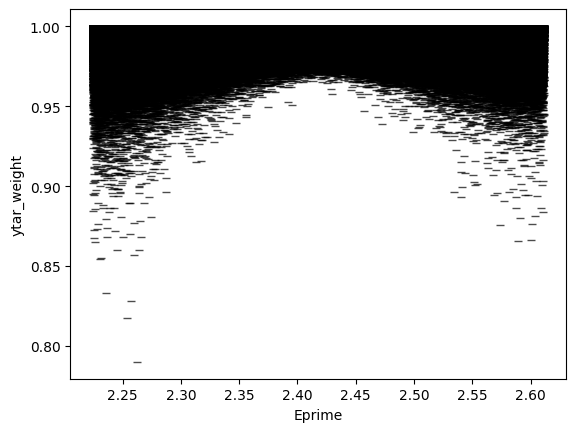

In [17]:
plt.plot(Eprime_dict[2.42], ytar_weight[2.42], '_', color = 'black', alpha = 0.7)
plt.xlabel('Eprime')
plt.ylabel('ytar_weight')

Text(0.5, 1.0, 'LD2 2.42 GeV MC')

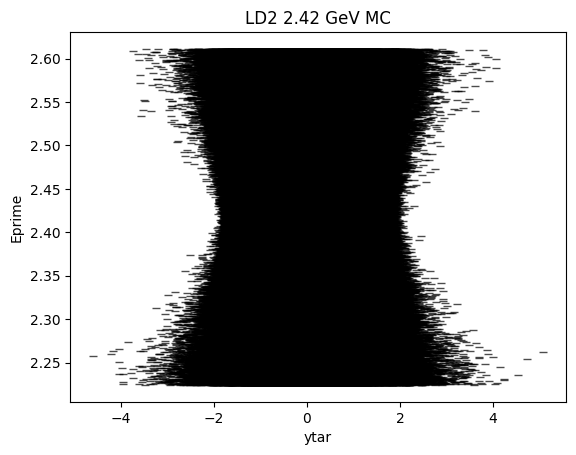

In [18]:
plt.plot(ytarcut[2.42], Eprime_dict[2.42], '_', color = 'black', alpha = 0.7)
plt.ylabel('Eprime')
plt.xlabel('ytar')
plt.title('LD2 2.42 GeV MC')

[1.70413542 2.63408909 2.58989782 2.59813703 2.59591613 2.52687637
 2.57283716 2.50845748 2.48817516 2.54633903 2.5290944  2.51928735
 2.49266705 2.51460454 2.48422199 2.45501141 2.46631205 2.46882624
 2.45137183 2.42412865 2.38203758 2.39506192 2.36744581 2.38665854
 2.34804037 2.29147659 2.25717909 2.26391313 2.24686481 2.23514477
 2.20355086 0.62038495]


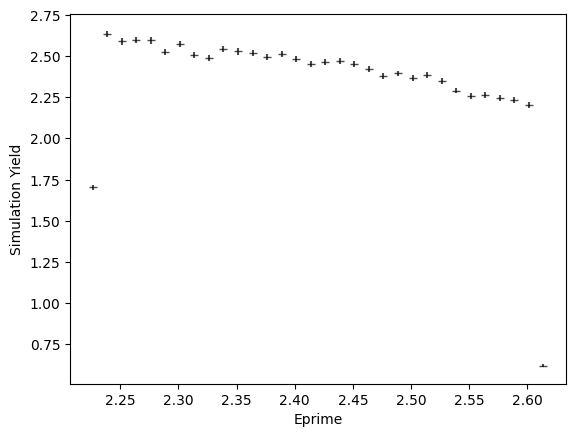

In [19]:
fig11, ax11 = plt.subplots()

ax11.errorbar(bini_centers_eprime_2p42[bini_counts_eprime_2p42 != 0], bini_counts_eprime_2p42[bini_counts_eprime_2p42 != 0], yerr = bini_errors_eprime_2p42[bini_counts_eprime_2p42 != 0], fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax11.set_xlabel('Eprime')
ax11.set_ylabel('Simulation Yield')
print(bini_counts_eprime_2p42[bini_counts_eprime_2p42 != 0])

[1.72281312 2.6621898  2.6166859  2.62337508 2.62026563 2.54991812
 2.59524859 2.52992031 2.50871315 2.56667693 2.54893852 2.53896845
 2.51177032 2.53369951 2.50276694 2.47358751 2.48490623 2.48755068
 2.47001    2.44259857 2.4002828  2.41354279 2.38619441 2.40587099
 2.36708424 2.31071154 2.27651635 2.28345569 2.26685971 2.25544009
 2.22411983 0.62632743]


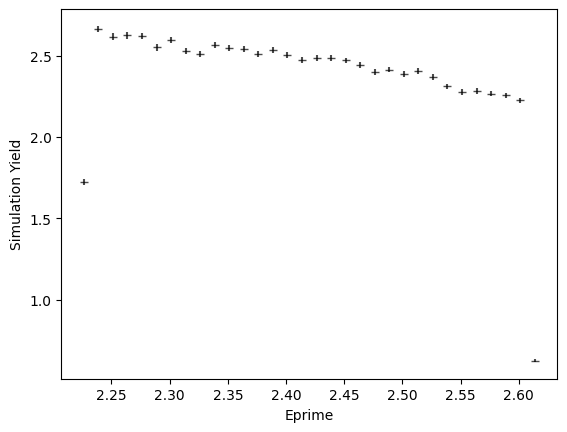

In [20]:
fig12, ax12 = plt.subplots()

ax12.errorbar(bin_centers_eprime_2p42[bin_counts_eprime_2p42 != 0], bin_counts_eprime_2p42[bin_counts_eprime_2p42 != 0], yerr = bin_errors_eprime_2p42[bin_counts_eprime_2p42 != 0], fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax12.set_xlabel('Eprime')
ax12.set_ylabel('Simulation Yield')
print(bin_counts_eprime_2p42[bin_counts_eprime_2p42 != 0])

[0.98915861 0.98944451 0.98976259 0.99037955 0.99070724 0.99096373
 0.99136444 0.9915164  0.99181333 0.99207617 0.99221475 0.99224839
 0.9923945  0.9924636  0.99259022 0.99249022 0.99251715 0.99247274
 0.99245421 0.99243841 0.99239872 0.99234285 0.99214288 0.99201435
 0.99195471 0.99167574 0.99150577 0.99144167 0.99117947 0.99100161
 0.99075186 0.99051218]


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/1329553798.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = bini_counts_eprime_2p42 / bin_counts_eprime_2p42


Text(0, 0.5, 'Ratio')

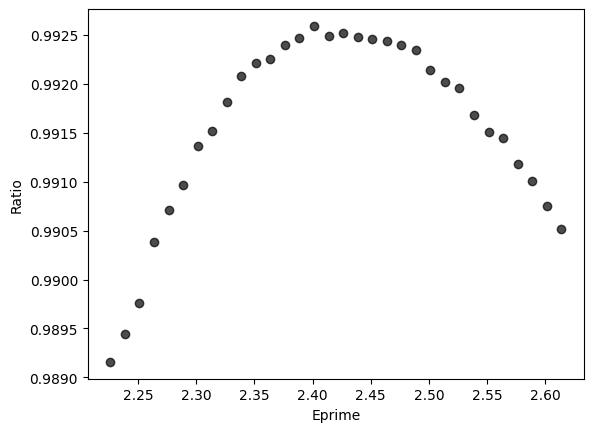

In [21]:
ratio = bini_counts_eprime_2p42 / bin_counts_eprime_2p42
print(ratio[~np.isnan(ratio)])
plt.plot(bin_centers_eprime_2p42, ratio, 'o', color = 'black', alpha = 0.7)
plt.xlabel('Eprime')
plt.ylabel('Ratio')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3265344129.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3265344129.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3265344129.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3265344129.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3265344129.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p4 = eprime_bin_contents_3p4/bin

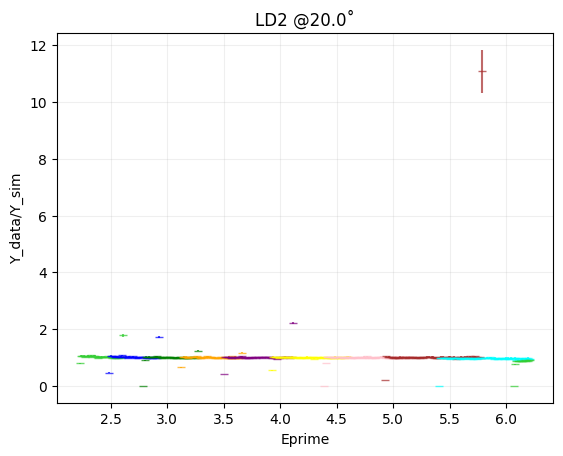

In [22]:
ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_counts_eprime_3p4
ratio_eprime_3p81 = eprime_bin_contents_3p81/bin_counts_eprime_3p81
ratio_eprime_4p27 = eprime_bin_contents_4p27/bin_counts_eprime_4p27
ratio_eprime_4p78 = eprime_bin_contents_4p78/bin_counts_eprime_4p78
ratio_eprime_5p36 = eprime_bin_contents_5p36/bin_counts_eprime_5p36
ratio_eprime_5p878 = eprime_bin_contents_5p878/bin_counts_eprime_5p878
ratio_eprime_6p6 = eprime_bin_contents_6p6/bin_counts_eprime_6p6

ratio_errors_2p42 = ratio_eprime_2p42 * np.sqrt((eprime_bin_errors_2p42/eprime_bin_contents_2p42)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)
ratio_errors_2p71 = ratio_eprime_2p71 * np.sqrt((eprime_bin_errors_2p71/eprime_bin_contents_2p71)**2 + (bin_errors_eprime_2p71/bin_counts_eprime_2p71)**2)
ratio_errors_3p04 = ratio_eprime_3p04 * np.sqrt((eprime_bin_errors_3p04/eprime_bin_contents_3p04)**2 + (bin_errors_eprime_3p04/bin_counts_eprime_3p04)**2)
ratio_errors_3p4 = ratio_eprime_3p4 * np.sqrt((eprime_bin_errors_3p4/eprime_bin_contents_3p4)**2 + (bin_errors_eprime_3p4/bin_counts_eprime_3p4)**2)
ratio_errors_3p81 = ratio_eprime_3p81 * np.sqrt((eprime_bin_errors_3p81/eprime_bin_contents_3p81)**2 + (bin_errors_eprime_3p81/bin_counts_eprime_3p81)**2)
ratio_errors_4p27 = ratio_eprime_4p27 * np.sqrt((eprime_bin_errors_4p27/eprime_bin_contents_4p27)**2 + (bin_errors_eprime_4p27/bin_counts_eprime_4p27)**2)
ratio_errors_4p78 = ratio_eprime_4p78 * np.sqrt((eprime_bin_errors_4p78/eprime_bin_contents_4p78)**2 + (bin_errors_eprime_4p78/bin_counts_eprime_4p78)**2)
ratio_errors_5p36 = ratio_eprime_5p36 * np.sqrt((eprime_bin_errors_5p36/eprime_bin_contents_5p36)**2 + (bin_errors_eprime_5p36/bin_counts_eprime_5p36)**2)
ratio_errors_5p878 = ratio_eprime_5p878 * np.sqrt((eprime_bin_errors_5p878/eprime_bin_contents_5p878)**2 + (bin_errors_eprime_5p878/bin_counts_eprime_5p878)**2)
ratio_errors_6p6 = ratio_eprime_6p6 * np.sqrt((eprime_bin_errors_6p6/eprime_bin_contents_6p6)**2 + (bin_errors_eprime_6p6/bin_counts_eprime_6p6)**2)

fig5, ax5 = plt.subplots()
ax5.errorbar(bin_centers_eprime_2p42, ratio_eprime_2p42, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax5.errorbar(bin_centers_eprime_2p71, ratio_eprime_2p71, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax5.errorbar(bin_centers_eprime_3p04, ratio_eprime_3p04, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax5.errorbar(bin_centers_eprime_3p4, ratio_eprime_3p4, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax5.errorbar(bin_centers_eprime_3p81, ratio_eprime_3p81, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax5.errorbar(bin_centers_eprime_4p27, ratio_eprime_4p27, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax5.errorbar(bin_centers_eprime_4p78, ratio_eprime_4p78, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax5.errorbar(bin_centers_eprime_5p36, ratio_eprime_5p36, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax5.errorbar(bin_centers_eprime_5p878, ratio_eprime_5p878, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax5.errorbar(bin_centers_eprime_6p6, ratio_eprime_6p6, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax5.set_xlabel('Eprime')
ax5.set_ylabel('Y_data/Y_sim')
ax5.set_title(f'{dtg} @{dang}˚')
ax5.grid(True, alpha = 0.2)
fig5.savefig(f'{folder}/ratio_eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>

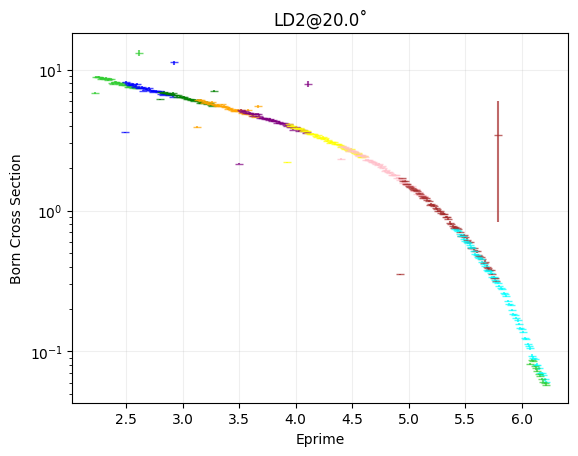

In [23]:
# Get points to interpolate based on angle and E'
points_to_interpolate_2p42 = np.column_stack((bin_centers_eprime_2p42, np.full(len(bin_centers_eprime_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((bin_centers_eprime_2p71, np.full(len(bin_centers_eprime_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((bin_centers_eprime_3p04, np.full(len(bin_centers_eprime_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((bin_centers_eprime_3p4, np.full(len(bin_centers_eprime_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((bin_centers_eprime_3p81, np.full(len(bin_centers_eprime_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((bin_centers_eprime_4p27, np.full(len(bin_centers_eprime_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((bin_centers_eprime_4p78, np.full(len(bin_centers_eprime_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((bin_centers_eprime_5p36, np.full(len(bin_centers_eprime_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((bin_centers_eprime_5p878, np.full(len(bin_centers_eprime_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((bin_centers_eprime_6p6, np.full(len(bin_centers_eprime_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42 = griddata(points, V6, points_to_interpolate_2p42, method='linear')
born_xsec_array_2p71 = griddata(points, V6, points_to_interpolate_2p71, method='linear')
born_xsec_array_3p04 = griddata(points, V6, points_to_interpolate_3p04, method='linear')
born_xsec_array_3p4 = griddata(points, V6, points_to_interpolate_3p4, method='linear')
born_xsec_array_3p81 = griddata(points, V6, points_to_interpolate_3p81, method='linear')
born_xsec_array_4p27 = griddata(points, V6, points_to_interpolate_4p27, method='linear')
born_xsec_array_4p78 = griddata(points, V6, points_to_interpolate_4p78, method='linear')
born_xsec_array_5p36 = griddata(points, V6, points_to_interpolate_5p36, method='linear')
born_xsec_array_5p878 = griddata(points, V6, points_to_interpolate_5p878, method='linear')
born_xsec_array_6p6 = griddata(points, V6, points_to_interpolate_6p6, method='linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42 = griddata(points, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71 = griddata(points, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04 = griddata(points, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4 = griddata(points, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81 = griddata(points, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27 = griddata(points, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78 = griddata(points, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36 = griddata(points, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878 = griddata(points, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6 = griddata(points, V13, points_to_interpolate_6p6, method = 'linear')

# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_dtg = ratio_eprime_2p42 * born_xsec_array_2p42 * ccf_2p42
born_cross_2p71_dtg = ratio_eprime_2p71 * born_xsec_array_2p71 * ccf_2p71
born_cross_3p04_dtg = ratio_eprime_3p04 * born_xsec_array_3p04 * ccf_3p04
born_cross_3p4_dtg= ratio_eprime_3p4 * born_xsec_array_3p4 * ccf_3p4
born_cross_3p81_dtg = ratio_eprime_3p81 * born_xsec_array_3p81 * ccf_3p81
born_cross_4p27_dtg = ratio_eprime_4p27 * born_xsec_array_4p27 * ccf_4p27
born_cross_4p78_dtg = ratio_eprime_4p78 * born_xsec_array_4p78 * ccf_4p78
born_cross_5p36_dtg = ratio_eprime_5p36 * born_xsec_array_5p36 * ccf_5p36
born_cross_5p878_dtg = ratio_eprime_5p878 * born_xsec_array_5p878 * ccf_5p878
born_cross_6p6_dtg= ratio_eprime_6p6 * born_xsec_array_6p6 * ccf_6p6

born_errors_2p42_dtg = born_cross_2p42_dtg * ratio_errors_2p42
born_errors_2p71_dtg = born_cross_2p71_dtg * ratio_errors_2p71
born_errors_3p04_dtg = born_cross_3p04_dtg * ratio_errors_3p04
born_errors_3p4_dtg = born_cross_3p4_dtg * ratio_errors_3p4
born_errors_3p81_dtg = born_cross_3p81_dtg * ratio_errors_3p81
born_errors_4p27_dtg = born_cross_4p27_dtg * ratio_errors_4p27
born_errors_4p78_dtg = born_cross_4p78_dtg * ratio_errors_4p78
born_errors_5p36_dtg = born_cross_5p36_dtg * ratio_errors_5p36
born_errors_5p878_dtg = born_cross_5p878_dtg * ratio_errors_5p878
born_errors_6p6_dtg = born_cross_6p6_dtg * ratio_errors_6p6

fig6, ax6 = plt.subplots()
ax6.errorbar(bin_centers_eprime_2p42, born_cross_2p42_dtg, yerr = born_errors_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax6.errorbar(bin_centers_eprime_2p71, born_cross_2p71_dtg, yerr = born_errors_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax6.errorbar(bin_centers_eprime_3p04, born_cross_3p04_dtg, yerr = born_errors_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax6.errorbar(bin_centers_eprime_3p4, born_cross_3p4_dtg, yerr = born_errors_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax6.errorbar(bin_centers_eprime_3p81, born_cross_3p81_dtg, yerr = born_errors_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax6.errorbar(bin_centers_eprime_4p27, born_cross_4p27_dtg, yerr = born_errors_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax6.errorbar(bin_centers_eprime_4p78, born_cross_4p78_dtg, yerr = born_errors_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax6.errorbar(bin_centers_eprime_5p36, born_cross_5p36_dtg, yerr = born_errors_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax6.errorbar(bin_centers_eprime_5p878, born_cross_5p878_dtg, yerr = born_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax6.errorbar(bin_centers_eprime_6p6, born_cross_6p6_dtg, yerr = born_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax6.set_xlabel('Eprime')
ax6.set_ylabel('Born Cross Section')
ax6.set_title(f'{dtg}@{dang}˚')
ax6.set_yscale('log')
#ax6.legend()
ax6.grid(True, alpha = 0.2)
fig6.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

Per-nucleon scaling factor: 116.0
slope -0.0829227362817721
high point 0.7840864095292118
low point 0.9592606899244553


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3122520365.py:10: RuntimeWarning: invalid value encountered in divide
  csr_3p04 = born_cross_3p04_ntg/born_cross_3p04_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3122520365.py:11: RuntimeWarning: invalid value encountered in divide
  csr_3p4 = born_cross_3p4_ntg/born_cross_3p4_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3122520365.py:13: RuntimeWarning: invalid value encountered in divide
  csr_4p27 = born_cross_4p27_ntg/born_cross_4p27_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3122520365.py:14: RuntimeWarning: invalid value encountered in divide
  csr_4p78 = born_cross_4p78_ntg/born_cross_4p78_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_90168/3122520365.py:16: RuntimeWarning: invalid value encountered in divide
  csr_5p878 = born_cross_5p878_ntg/born_cross_5p878_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000g

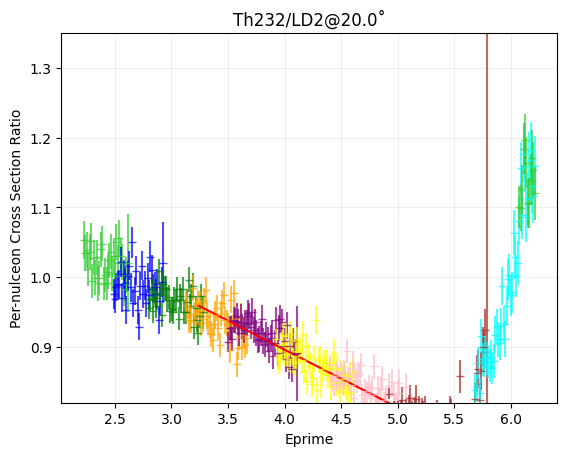

In [24]:
nA = target_info[ntg][1]
nZ = target_info[ntg][0]
dA = target_info[dtg][1]

sf = nA/dA
print("Per-nucleon scaling factor:", sf)

csr_2p42 = born_cross_2p42_ntg/born_cross_2p42_dtg/sf
csr_2p71 = born_cross_2p71_ntg/born_cross_2p71_dtg/sf
csr_3p04 = born_cross_3p04_ntg/born_cross_3p04_dtg/sf
csr_3p4 = born_cross_3p4_ntg/born_cross_3p4_dtg/sf
csr_3p81 = born_cross_3p81_ntg/born_cross_3p81_dtg/sf
csr_4p27 = born_cross_4p27_ntg/born_cross_4p27_dtg/sf
csr_4p78 = born_cross_4p78_ntg/born_cross_4p78_dtg/sf
csr_5p36 = born_cross_5p36_ntg/born_cross_5p36_dtg/sf
csr_5p878 = born_cross_5p878_ntg/born_cross_5p878_dtg/sf
csr_6p6 = born_cross_6p6_ntg/born_cross_6p6_dtg/sf

csr_errors_2p42 = csr_2p42 * np.sqrt((born_errors_2p42_ntg/born_cross_2p42_ntg)**2 + (born_errors_2p42_dtg/born_cross_2p42_dtg)**2)
csr_errors_2p71 = csr_2p71 * np.sqrt((born_errors_2p71_ntg/born_cross_2p71_ntg)**2 + (born_errors_2p71_dtg/born_cross_2p71_dtg)**2)
csr_errors_3p04 = csr_3p04 * np.sqrt((born_errors_3p04_ntg/born_cross_3p04_ntg)**2 + (born_errors_3p04_dtg/born_cross_3p04_dtg)**2)
csr_errors_3p4 = csr_3p4 * np.sqrt((born_errors_3p4_ntg/born_cross_3p4_ntg)**2 + (born_errors_3p4_dtg/born_cross_3p4_dtg)**2)
csr_errors_3p81 = csr_3p81 * np.sqrt((born_errors_3p81_ntg/born_cross_3p81_ntg)**2 + (born_errors_3p81_dtg/born_cross_3p81_dtg)**2)
csr_errors_4p27 = csr_4p27 * np.sqrt((born_errors_4p27_ntg/born_cross_4p27_ntg)**2 + (born_errors_4p27_dtg/born_cross_4p27_dtg)**2)
csr_errors_4p78 = csr_4p78 * np.sqrt((born_errors_4p78_ntg/born_cross_4p78_ntg)**2 + (born_errors_4p78_dtg/born_cross_4p78_dtg)**2)
csr_errors_5p36 = csr_5p36 * np.sqrt((born_errors_5p36_ntg/born_cross_5p36_ntg)**2 + (born_errors_5p36_dtg/born_cross_5p36_dtg)**2)
csr_errors_5p878 = csr_5p878 * np.sqrt((born_errors_5p878_ntg/born_cross_5p878_ntg)**2 + (born_errors_5p878_dtg/born_cross_5p878_dtg)**2)
csr_errors_6p6 = csr_6p6 * np.sqrt((born_errors_6p6_ntg/born_cross_6p6_ntg)**2 + (born_errors_6p6_dtg/born_cross_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
ax7.errorbar(bin_centers_eprime_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax7.errorbar(bin_centers_eprime_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax7.errorbar(bin_centers_eprime_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax7.errorbar(bin_centers_eprime_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax7.errorbar(bin_centers_eprime_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax7.errorbar(bin_centers_eprime_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax7.errorbar(bin_centers_eprime_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax7.errorbar(bin_centers_eprime_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax7.errorbar(bin_centers_eprime_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax7.errorbar(bin_centers_eprime_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax7.set_xlabel('Eprime')
ax7.set_ylabel('Per-nulceon Cross Section Ratio')
ax7.set_title(f'{ntg}/{dtg}@{dang}˚')
ax7.grid(True, alpha = 0.2)
ax7.set_ylim(0.82, 1.35)

csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bin_centers = np.concatenate((bin_centers_eprime_2p42, bin_centers_eprime_2p71, bin_centers_eprime_3p04, bin_centers_eprime_3p4, bin_centers_eprime_3p81, bin_centers_eprime_4p27, bin_centers_eprime_4p78, bin_centers_eprime_5p36, bin_centers_eprime_5p878, bin_centers_eprime_6p6))
mask = (bin_centers >= 3.23) & (bin_centers <= 5.36) & ~np.isnan(csr)
filtered_csr = csr[mask]
filtered_bin_centers = bin_centers[mask]
# for i in range(len(filtered_csr)):
#     print(f"{filtered_bin_centers[i]} {filtered_csr[i]}")

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("slope", slope)
print("high point", slope * np.max(filtered_bin_centers) + intercept)
print("low point", slope * np.min(filtered_bin_centers) + intercept)
ax7.plot(filtered_bin_centers, slope*filtered_bin_centers + intercept, 'r')
fig7.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<ErrorbarContainer object of 3 artists>

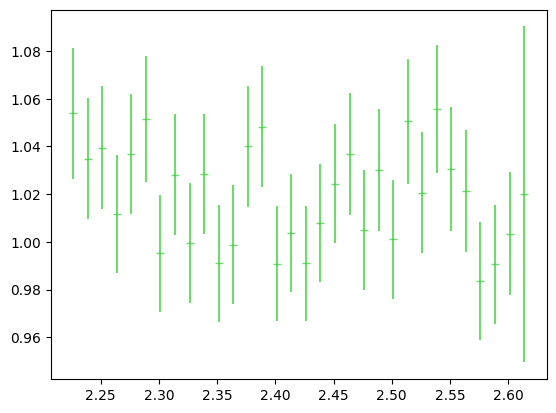

In [25]:
fig10, ax10 = plt.subplots()
ax10.errorbar(bin_centers_eprime_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')

<h1 align="center">Converting to Bjorken-x</h1>

absolute value of slope 0.44610143008587033
low point 0.7727101712693423
EMC Ratio at x=0.3: 0.9503349180542362


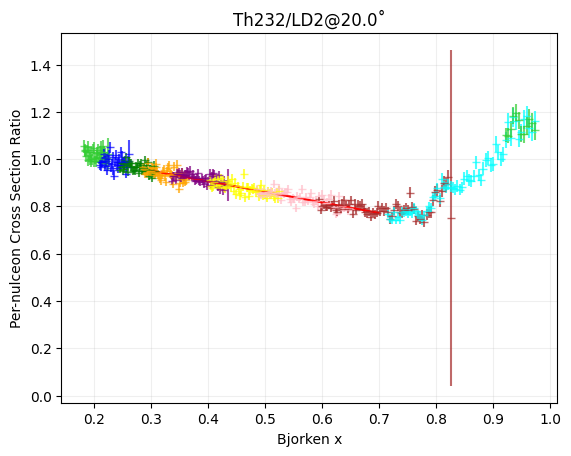

In [26]:
bin_centers_bjx_2p42 = (4 * Ei * bin_centers_eprime_2p42 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_2p42))
bin_centers_bjx_2p71 = (4 * Ei * bin_centers_eprime_2p71 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_2p71))
bin_centers_bjx_3p04 = (4 * Ei * bin_centers_eprime_3p04 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p04))
bin_centers_bjx_3p4 = (4 * Ei * bin_centers_eprime_3p4 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p4))
bin_centers_bjx_3p81 = (4 * Ei * bin_centers_eprime_3p81 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p81))
bin_centers_bjx_4p27 = (4 * Ei * bin_centers_eprime_4p27 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_4p27))
bin_centers_bjx_4p78 = (4 * Ei * bin_centers_eprime_4p78 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_4p78))
bin_centers_bjx_5p36 = (4 * Ei * bin_centers_eprime_5p36 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_5p36))
bin_centers_bjx_5p878 = (4 * Ei * bin_centers_eprime_5p878 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_5p878))
bin_centers_bjx_6p6 = (4 * Ei * bin_centers_eprime_6p6 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_6p6))

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax8.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax8.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('Per-nulceon Cross Section Ratio')
ax8.set_title(f'{ntg}/{dtg}@{dang}˚')
ax8.grid(True, alpha = 0.2)

bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= 0.3) & (bjx_bin_centers <= 0.7) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("low point", slope*np.max(filtered_bin_centers) + intercept)
print("EMC Ratio at x=0.3:", slope*np.min(filtered_bin_centers) + intercept)
ax8.plot(filtered_bin_centers, slope*filtered_bin_centers + intercept, 'r')
fig8.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

# Write the cross-section ratio to a text file

In [27]:
filepath = f"{folder}/csr_{ntg}_{dtg}_{dang}.txt"
with open(filepath, "w") as file:
    for i in range(len(bin_centers_bjx_2p42)):
        file.write(f"{bin_centers_bjx_2p42[i]}\t{csr_2p42[i]}\t{csr_errors_2p42[i]}\t{csr_2p71[i]}\t{csr_errors_2p71[i]}\t{csr_3p04[i]}\t{csr_errors_3p04[i]}\t{csr_3p4[i]}\t{csr_errors_3p4[i]}\t{csr_3p81[i]}\t{csr_errors_3p81[i]}\t{csr_4p27[i]}\t{csr_errors_4p27[i]}\t{csr_4p78[i]}\t{csr_errors_4p78[i]}\t{csr_5p36[i]}\t{csr_errors_5p36[i]}\t{csr_5p878[i]}\t{csr_errors_5p878[i]}\t{csr_6p6[i]}\t{csr_errors_6p6[i]}\n")

# Calculating isoscalar correction factor

In [28]:
isoscalar_all = np.zeros(len(bin_centers_eprime_2p42))
q2_all = 4 * Ei * bin_centers_eprime_2p42 * (np.sin(dang * np.pi / 180 / 2))**2
i = 0

for i in range(len(bin_centers_eprime_2p42)):
    isoscalar_all[i] = jra_nprat(bin_centers_bjx_2p42[i], q2_all[i])
    i += 1

print("Average of q2_all", np.mean(q2_all))
print("Average of Bjorken x", np.mean(bin_centers_bjx_2p42))
print("Length and average of isoscalar_2p42", len(isoscalar_all), np.mean(isoscalar_all))
# print("csr_2p42", csr_2p42)

Average of q2_all 5.364799717175475
Average of Bjorken x 0.4925209912813758
Length and average of isoscalar_2p42 320 0.5327278468533404


# Calculating and Plotting the final Cross-Section Ratios

nN 142
nZ 90
nA 232
Mean of isoscalar_factor 1.077607882317741
absolute value of isoscalar corrected slope 0.34998758908425703
Error on slope 0.01145101911380992
EMC Ratio at x = 0.3: 0.9975348640325807


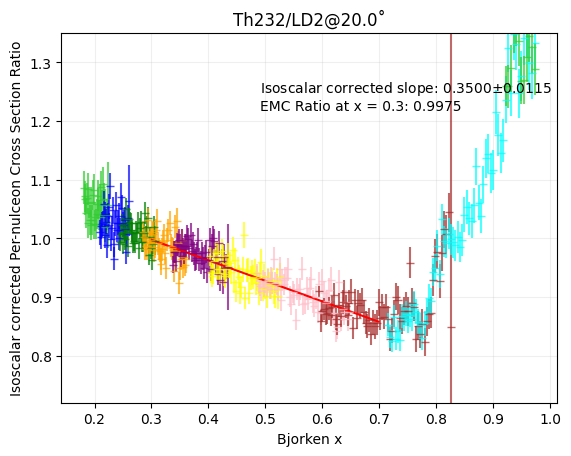

In [29]:
nN = nA - nZ
print("nN", nN)
print("nZ", nZ)
print("nA", nA)
isoscalar_factor = (nA/2 * (1 + isoscalar_all))/(nZ + (nN * isoscalar_all))
print("Mean of isoscalar_factor", np.mean(isoscalar_factor))

# Apply isoscalar correction to cross-section ratios
iso_csr_2p42 = csr_2p42 * isoscalar_factor
iso_csr_2p71 = csr_2p71 * isoscalar_factor
iso_csr_3p04 = csr_3p04 * isoscalar_factor
iso_csr_3p4 = csr_3p4 * isoscalar_factor
iso_csr_3p81 = csr_3p81 * isoscalar_factor
iso_csr_4p27 = csr_4p27 * isoscalar_factor
iso_csr_4p78 = csr_4p78 * isoscalar_factor
iso_csr_5p36 = csr_5p36 * isoscalar_factor
iso_csr_5p878 = csr_5p878 * isoscalar_factor
iso_csr_6p6 = csr_6p6 * isoscalar_factor

fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, iso_csr_2p42, yerr = isoscalar_factor * csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, iso_csr_2p71, yerr = isoscalar_factor * csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, iso_csr_3p04, yerr = isoscalar_factor * csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, iso_csr_3p4, yerr = isoscalar_factor * csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, iso_csr_3p81, yerr = isoscalar_factor * csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, iso_csr_4p27, yerr = isoscalar_factor * csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, iso_csr_4p78, yerr = isoscalar_factor * csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, iso_csr_5p36, yerr = isoscalar_factor * csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax9.errorbar(bin_centers_bjx_5p878, iso_csr_5p878, yerr = isoscalar_factor * csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax9.errorbar(bin_centers_bjx_6p6, iso_csr_6p6, yerr = isoscalar_factor * csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax9.set_xlabel('Bjorken x')
ax9.set_ylabel('Isoscalar corrected Per-nulceon Cross Section Ratio')
ax9.set_title(f'{ntg}/{dtg}@{dang}˚')
ax9.grid(True, alpha = 0.2)
# ax9.legend()

iso_csr = np.concatenate((iso_csr_2p42, iso_csr_2p71, iso_csr_3p04, iso_csr_3p4, iso_csr_3p81, iso_csr_4p27, iso_csr_4p78, iso_csr_5p36, iso_csr_5p878, iso_csr_6p6))
filtered_iso_csr = iso_csr[mask]

iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(filtered_bin_centers, filtered_iso_csr)
print("absolute value of isoscalar corrected slope", abs(iso_slope))
norm_3 = iso_slope * np.min(filtered_bin_centers) + iso_intercept
print("Error on slope", iso_std_err)
print("EMC Ratio at x = 0.3:", norm_3)
ax9.plot(filtered_bin_centers, iso_slope * filtered_bin_centers + iso_intercept, 'r')
ax9.set_ylim(0.72, 1.35)
ax9.text(0.4, 0.79, f'Isoscalar corrected slope: {abs(iso_slope):.4f}$\pm${iso_std_err:.4f} \nEMC Ratio at x = 0.3: {norm_3:.4f}', transform = ax9.transAxes)
fig9.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

In [30]:
samapti = time.time()
seconds = samapti - start_time
minutes = seconds / 60
print(f"Time taken: {minutes:.2f} minutes")

Time taken: 6.42 minutes


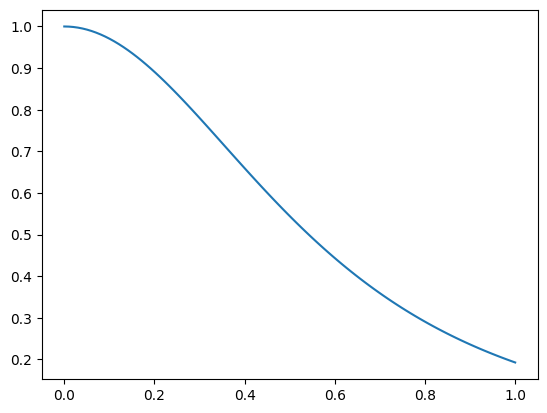

In [31]:
import numpy as np
import matplotlib.pyplot as plt
xptar = np.linspace(0, 1, 100)
yptar = np.linspace(0, 1, 100)
k = 1.0 / np.power((1 + np.power(xptar, 2) + np.power(yptar, 2)), 1.5)
plt.plot(yptar, k)